In [24]:
%load_ext autoreload
%autoreload 2

In [77]:
from array_utils import load_npz, write_npz
import numpy as np
import matplotlib.pyplot as plt
import os

In [39]:
# path = 'mnist/results/stats_0.npz'
# load_npz(path)

data = {"lol": np.array([10])}

write_npz('results', 'test.npz', data)
load_npz('results/test.npz')


Recording stats to results/test.npz


{'lol': array([10])}

In [67]:
from metrics_lib import compute_accuracies_at_confidences

In [75]:
thresholds = np.linspace(0, 1, 10, endpoint=True)

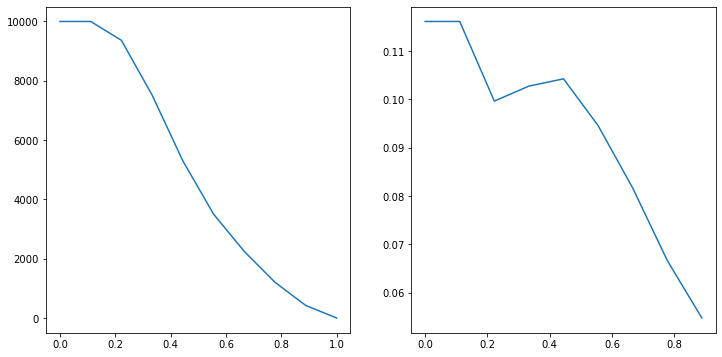

In [76]:
stats = load_npz('mnist/results/svi/stats_small_28.npz')
accuracies, count = compute_accuracies_at_confidences(stats['labels'], stats['probs'], thresholds)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(thresholds, count)
plt.subplot(122)
plt.plot(thresholds, accuracies)
plt.show()

vanilla [10000. 10000.  9999.  9959.  9724.  9126.  8356.  7394.  6327.   308.]
svi [10000. 10000.  9365.  7515.  5296.  3500.  2241.  1200.   420.     0.]


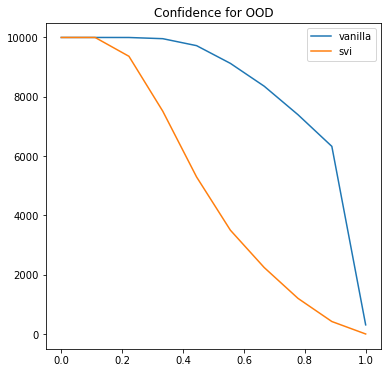

In [87]:
ood_name = 'stats_small_28.npz'
methods = ['vanilla', 'svi']
counts = {}
for method in methods:
    path = os.path.join('mnist/results/',method, ood_name)
    stats = load_npz(path)
    _, counts[method] = compute_accuracies_at_confidences(stats['labels'], stats['probs'], thresholds)

plt.figure(figsize=(6,6))
for method, count in counts.items():
    print(method, count)
    plt.plot(thresholds, count, label=method)
plt.title('Confidence for OOD')
plt.legend()
plt.show()